# Random graphs

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

One way of trying to understand a new network is by comparing it to networks constructed by random processes governed by fairly simple rules. if the network has quantitative properties similar to those of some random family, we may suppose that the construction rules of that family have some bearing on the way our network came into being.

An **Erdős-Rényi graph** includes each individual possible edge with a fixed probability $p$. When one refers to a "random graph" without any additional context, this is usually the type that is meant.

In [2]:
n,p = 60,0.08
ER = nx.erdos_renyi_graph(n,p,seed=1)
print(er.number_of_nodes(),"nodes,",ER.number_of_edges(),"edges")
nx.draw_circular(ER,node_size=40)

NameError: name 'er' is not defined

Since there are $\binom{n}{2}$ possible edges in an undirected graph on $n$ nodes, the mean number of edges in an ER graph is 

$$
\frac{pn(n-1)}{2}.
$$

This fact is usually stated in different terms. The **degree** of a node is the number of edges that have the node as an endpoint. The `degree` property of a graph returns an iterator that can be collected into a list or frame.

In [3]:
degrees = pd.DataFrame(ER.degree,columns=["node","degree"])
degrees.head()

,node,degree
0,0,7
1,1,5
2,2,7
3,3,3
4,4,6


In any graph, if we add the degrees of all the nodes, then we must get twice the number of edges. Thus, in an ER graph, the average node degree is, on average,

$$
\bar{k} = \frac{1}{n} pn(n-1) = p(n-1).
$$

In [4]:
print("Average degree in ER graph above:",degrees["degree"].mean())
print("Theoretical expectation:",p*(n-1))

Average degree in ER graph above: 4.833333333333333
Theoretical expectation: 4.72


Note that we are talking here about the average (over all ER graphs of type $(n,p)$) of the value of the average (over the nodes in one graph) degree. Here is the distribution of $\bar{k}$ over many instances.

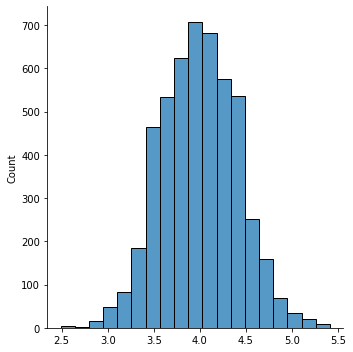

In [5]:
n,p = 41,0.1
kbar = []
for i in range(5000):
    ER = nx.erdos_renyi_graph(n,p)
    deg = pd.DataFrame(ER.degree,columns=["node","degree"])["degree"]
    kbar.append(deg.mean())

sns.displot(x=kbar,bins=19);

## Degree distribution

As we know, means of distributions do not always tell the entire story. For example, here is the distribution of the degrees of all the nodes in our Twitch network example.

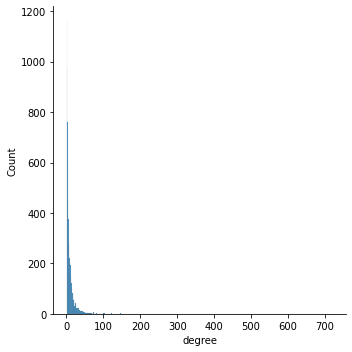

In [6]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
twitch_degrees = pd.DataFrame(twitch.degree,columns=["node","degree"])
hist = sns.displot(data=twitch_degrees,x="degree")

We can find the average degree of this network and create an ER graph with the same expected average degree.

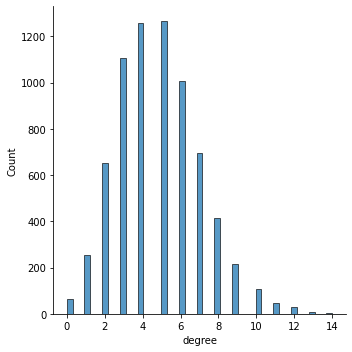

In [7]:
n = twitch.number_of_nodes()
kbar = degrees["degree"].mean()
p = kbar/(n-1)
ER = nx.erdos_renyi_graph(n,p)
degrees = pd.DataFrame(ER.degree,columns=["node","degree"])
hist = sns.displot(data=degrees,x="degree")

It's obvious now that the ER graph is nothing like the Twitch graph. While nobody in the ER graph has more than 30 friends, a few nodes in the Twitch network have hundreds of friends.

The behavior of the Twitch degree distribution gets very interesting when the axes are transformed to use log scales:

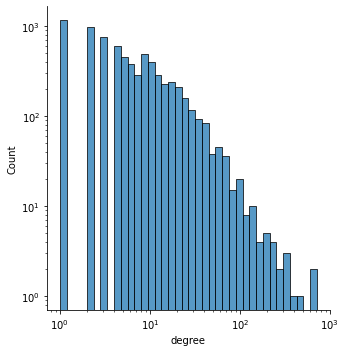

In [8]:
hist = sns.displot(data=twitch_degrees,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

For degrees between 10 and several hundred, the counts lie nearly on a straight line. That is, if $x$ is degree and $y$ is the node count at that degree, then

$$
\log(y) \approx  - a\cdot \log(x) + b,
$$

i.e.,

$$
y \approx B x^{-a},
$$

for some $a > 0$. This relationship is known as a **power law**. Many social networks follow to some extent a power-law distrubution of node degrees. (The extent to which this statement is true is a hot debate within network science.)

We can get a fair estimate of the constants $B$ and $a$ in the power law by doing a least-squares fit on the logs of $x$ and $y$. First, we need the counts:

In [9]:
y = twitch_degrees["degree"].value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["count"] > 10) & (counts["count"] < 200)];

Now we will get additional columns by log transformations. (Note: the `np.log` function is the natural logarithm.)

In [10]:
counts[["log_x","log_y"]] = counts.transform(np.log)

Now we use `sklearn` for a linear regression.

In [11]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(counts[["log_x"]],counts["log_y"])
print("slope",lm.coef_[0],"and intercept",lm.intercept_)

slope -2.135847745320904 and intercept 10.397579197774625


If the average degree in any graph is less than 1, then at least one node must have degree less than one. Therefore, the graph is not connected. For ER graphs, $\bar{k} = 1$ marks a crucial transition. Let's fix $n$ and look at the size of the largest connected component of ER graphs as $p$ varies.

In [12]:
n = 201
results = pd.DataFrame({"p":[],"kbar":[],"size":[]})
for p in np.arange(0.0001,0.025,0.0004):
    for i in range(50):
        ER = nx.erdos_renyi_graph(n,p)
        largest_cc = max(len(g) for g in nx.connected_components(ER))
        results = pd.concat((results,
                             pd.DataFrame({"p":[p],"kbar":p*(n-1),"size":largest_cc})),
                            ignore_index=True)

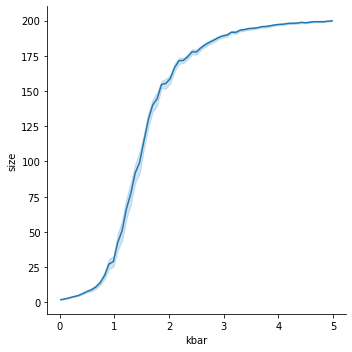

In [13]:
sns.relplot(data=results,x="kbar",y="size",kind="line");

The plot above suggests that as $\bar{k}$ increases past 1, there is often a "giant component" that dominates the graph.

In [14]:
degrees = pd.DataFrame(twitch.degree,columns=["node","degree"])
degrees

,node,degree
0,6194,6
1,255,6
2,980,18
3,2992,4
4,2507,22
...,...,...
7121,2933,1
7122,2267,1
7123,6694,1
7124,6995,1


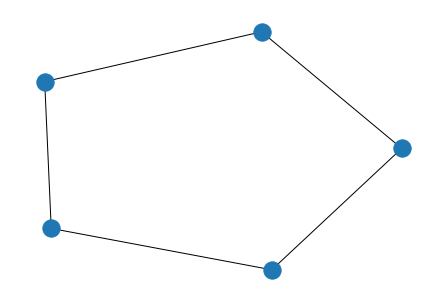

In [15]:
nx.draw(nx.cycle_graph(5))

A **Watts–Strogatz graph** tries to model the "small-world" phenomenon of social networks, where most members can be connected by a suprirsingly short walk along edges. A WS graph has three parameters: $n$, an even integer $k$, and a probability $p$. 

Imagine $n$ nodes arranged in a circle. Connect each node with an edge to each of its $k/2$ left neighbors and $k/2$ right neighbors. Now visit each node $i$ in turn. For each edge from $i$ to a neighbor, with probability $p$ replace it with an edge between $i$ and a node chosen at random from all the nodes $i$ is not currently connected to.

The first value, which is both the slope of the line and the exponent of $x$ the power law, is the most interesting part. It estimates that the degree counts vary as $Bx^{-2.1}$ over a wide range of degrees.

A certain type of random graph known as a **Barabási–Albert** graph is constructed by connecting one node at a time. Edges are added randomly, but preference is given to connect to nodes that already have higher degree (i.e., are more "popular"). Because of this rule, there is a natural tendency to develop a few hubs of high degree.

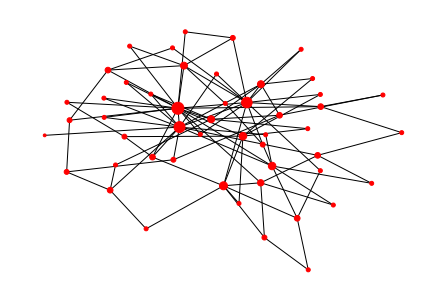

In [16]:
bag = nx.barabasi_albert_graph(50,2,seed=0)
bag_deg = pd.DataFrame(bag.degree,columns=["node","degree"])

nx.draw(bag,node_size=8*bag_deg["degree"],node_color="red")

When we scale the construction up to the size and average degree of the Twitch network, a power-law distribution emerges.

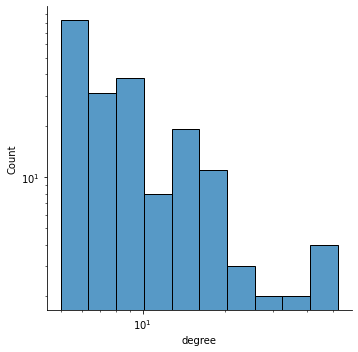

In [17]:
bag = nx.barabasi_albert_graph(n,round(p*n),seed=0)
bag_deg = pd.DataFrame(bag.degree,columns=["node","degree"])
hist = sns.displot(data=bag_deg,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

Compared to selecting from all possible edges with equal probabiliy, the Barabási–Albert model is considered a more plausible idealization of how social networks form.

## Distance

The **distance** between two nodes in a connected graph is the number of edges in the shortest path between them. This concept appears in the "Bacon number" game, where actors are nodes, appearing in the same movie creates an edge between them, and one tries to find the distance between Kevin Bacon and some other designated actor. 

The number of pairs of nodes in our Twitch network is moderately large.

In [18]:
print(n,"nodes create",(n-1)*n//2,"possible pairings")

201 nodes create 20100 possible pairings


It would take a while on a typical laptop to compute the distances between all such pairs. Instead, we will just randomly sample a healthy number of them.

In [19]:
from numpy.random import default_rng
rng = default_rng(1)
def pairdist(G,n):
    i = j = rng.integers(0,n)
    while i==j: j = rng.integers(0,n)
    return nx.shortest_path_length(G,source=i,target=j)

dist = [pairdist(twitch,n) for _ in range(100000)]
distances = pd.Series(dist)

In [20]:
distances.value_counts()

4    39467
3    37255
5    13957
2     5804
6     3077
7      253
1      164
8       23
dtype: int64

With over 7100 nodes, and an average of about 10 edges per node, the average distance between nodes is less than 4:

In [21]:
distances.mean()

3.71607

Node distances are related to the notion of "six degrees of separation" between any two people on Earth. This is a statement about the **diameter**, or maximum distance, of the human friendship network. In network analysis, this notion is called the *small-word phenomenon*. It's usually stated in terms of the mean degree, not the maximum, since the diameter can be determined by a single pair. (Even the little Twitch network above has a diameter of at least 9.) For a random network on $n$ nodes that have average degree $d$, the mean distance is approximately $\ln(n)/d$. For a scale-free network, it is even less.

In [22]:
from numpy.random import default_rng
rng = default_rng(1)

distances = pd.Series([pairdist(bag,n) for _ in range(100000)])

In [23]:
distances.mean()

2.47147

## Clustering

The small-world question is related to another type of network measurement: **clustering**. There are many ways to assess clustering, but we will use the **local clustering coefficient**. 

Suppose that node $i$ is adacent to $k$ other nodes, called its **neighborhood** (or level-1 ego graph). The nodes in the neighborhood have $k(k-1)/2$ possible edges between them. Suppose that there are $m$ edges between members of the neighborhood (exclusive of node $i$). The clustering coefficient of node $i$ is defined as

$$
c_i = \frac{2m}{k(k-1)}.
$$

If $c_i=0$, the neighborhood is starlike: none of the neighbors "talk to" (i.e., are adjacent to) each other. At the other extreme, if $c_i=1$, then the subgraph of the neighborhood is a complete graph. 

For example, here is the neighborhood of node 400.

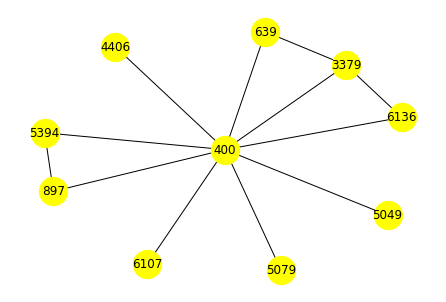

In [24]:
nbhood = nx.ego_graph(twitch,400)
nx.draw(nbhood,with_labels=True,node_size=800,node_color="yellow")

The plot reveals that the neighborhood has only 3 edges aside from those linking to node 400. Since there are 9 nodes in the neighborhood, this gives a clustering of 

$$
\frac{6}{9\cdot 8} = \frac{1}{12}.
$$

There is a function for computing this value, of course.

In [25]:
nx.clustering(twitch,400)

0.08333333333333333

The mean clustering coefficient is one way to assess the small-worldness of a graph.

In [26]:
pd.Series(nx.clustering(twitch)).mean()

0.13092821901472096

How do we put this number in context? The random BA graph has a much lower value.

In [27]:
pd.Series(nx.clustering(bag)).mean()

0.12111542814826917

This confirms that the BA construction does nothing to build community structure, only hubs. A Watts–Strogatz graph, on the other hand, starts from communities and just rewires some of the edges to create shortcuts. If we start from neighborhoods of size 10, the mean clustering is high:

In [28]:
ws = nx.watts_strogatz_graph(n,10,0,seed=2)
pd.Series(nx.clustering(ws)).mean()

0.666666666666668

However, the mean path length in that graph would be large, since there are no far-flung direct connections. But if we allow 40% of the links to be converted to random destinations, then the clustering is similar to the Twitch graph:

In [29]:
ws = nx.watts_strogatz_graph(n,10,0.4,seed=11)
pd.Series(nx.clustering(ws)).mean()

0.1761863067833217

The mean distance is also comparable:

In [30]:
rng = default_rng(1)
pd.Series([pairdist(ws,n) for _ in range(50000)]).mean()

2.66046

As we computed above, the Twitch network has an even smaller mean distance, making it a bit more efficient at connecting nodes by paths.